# Describe the properties of the place graph

Compute the graph properties: density, connectivity, diameter, etc.

- Graph without threshold
- Graph with threshold = 1000

TBD: Check the properties for the heterogenous graphs (graph for dif times, activity types, etc.)


Note the benchmarks from Jure Leskovec's MSN network.

- Degree distribution: heavily skewed (power law), avg degree = 14.4
- Path length: 6.6
- Clustering coefficient: 0.11
- Connectivity: giant component

J. Leskovec, E. Horvitz. Worldwide Buzz: Planetary-Scale Views on an Instant-Messaging Network. Proc. International WWW Conference, 2008

https://chih-ling-hsu.github.io/2020/05/15/network-example#connectivity


In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import copy

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
# read files.
with open("../../data/03_processed/place_graph_A.pickle", 'rb') as f:
    A_place = pickle.load(f) # sparse matrix

with open("../../data/03_processed/place_graph_weighted_A.pickle", 'rb') as f:
    A_weighted_place = pickle.load(f) # sparse matrix    


In [4]:
A_weighted_place.shape

(3102, 3102)

## Describe the adjacency matrix without threshold filters (threshold = 0)

In [5]:
# describe the weighted A.
# very long tail distribution. 
A_weighted_array = A_weighted_place.toarray()
print(np.sum(A_weighted_array))
pd.DataFrame(A_weighted_array.reshape(-1, 1)).describe()

5540883983.0


,0
count,9.622404e+06
mean,5.758316e+02
std,2.983038e+04
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,2.600000e+01
max,2.358477e+07


In [7]:
# define the threshold
epsilon = 0.0

In [9]:
# create a threshold to filter the weighting array.
A_threshold = copy.copy(A_weighted_array)
smaller_than_threshold_mask = A_threshold < epsilon
A_threshold[smaller_than_threshold_mask] = 0.0
larger_than_threshold_mask = A_threshold > epsilon
A_threshold[larger_than_threshold_mask] = 1.0

print("Num of edges in the new adjacency matrix: ", np.sum(A_threshold))
print("Num of edges in the initial adjacency matrix: ", np.sum(A_place))
print("Total number of potential edges: ", A_place.shape[0]*A_place.shape[1])

# very dense

A_threshold

Num of edges in the new adjacency matrix:  5290846.0
Num of edges in the initial adjacency matrix:  5290846.0
Total number of potential edges:  9622404


array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.]])

In [10]:
# Obtain the characters of the graph. 
# density, diameter, etc. 
G = nx.from_numpy_matrix(A_threshold)

In [11]:
# density
print(nx.density(G))

0.5503463764834496


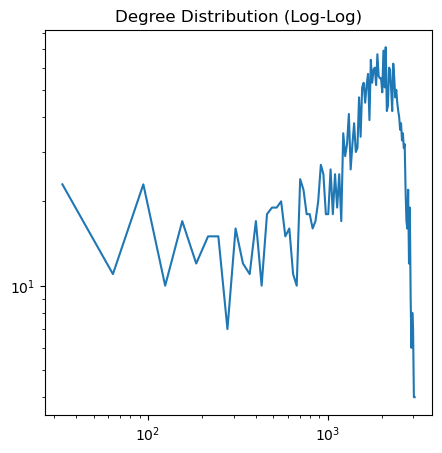

Average degree is:  1706.6241134751774


In [13]:
# degree distribution.
degree_dict = dict(nx.degree(G))
degree_counts = degree_dict.values()

degree_hist, degree_bins, _ = plt.hist(degree_counts, bins=100)
plt.close()

fig, ax = plt.subplots(figsize = (5, 5))
ax.loglog(degree_bins[1:], degree_hist)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(title = 'Degree Distribution (Log-Log)')
plt.show()

print("Average degree is: ", np.mean(list(degree_counts)))

# print(hist)
# print(bins)

In [14]:
# number of components
print(nx.number_connected_components(G))

1


In [16]:
# clustering coeffcient. 
# This block is very slow. 
clustering_dict = nx.clustering(G)
clustering_keys = clustering_dict.keys()
clustering_values = clustering_dict.values()

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

In [19]:
# average clustering coefficient
# so big.
print("Average clustering coefficient: ", np.mean(list(clustering_values)))


Average clustering coefficient:  0.7834505847498722


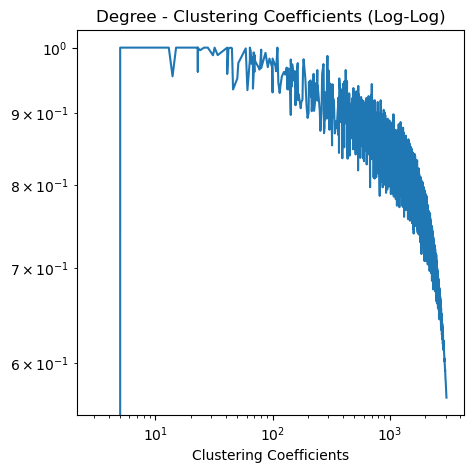

In [20]:
# clustering_values
degree_counts

degree_cluster_df = pd.DataFrame([list(degree_counts), list(clustering_values)]).T
degree_cluster_df.columns = ['degree', 'clustering_coeff']
degree_cluster_df = degree_cluster_df.sort_values('degree').reset_index()
degree_cluster_df

fig, ax = plt.subplots(figsize = (5, 5))
ax.loglog(degree_cluster_df['degree'], degree_cluster_df['clustering_coeff'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_xlabel('Clustering Coefficients')
ax.set(title = 'Degree - Clustering Coefficients (Log-Log)')
plt.show()


In [ ]:
# Component diameter 
# This line is VERY VERY SLOW...
# I cannot get a number. 
largest_G_nodes = max(nx.connected_components(G), key=len)
largest_sub_G = G.subgraph(largest_G_nodes)
print(nx.diameter(largest_sub_G)) # it takes time to compute.


## Describe the adjacency matrix with threshold filters (threshold = 1000)

In [21]:
# create the array
A_weighted_array = A_weighted_place.toarray()
print(np.sum(A_weighted_array))
# describe
pd.DataFrame(A_weighted_array.reshape(-1, 1)).describe()

5540883983.0


,0
count,9.622404e+06
mean,5.758316e+02
std,2.983038e+04
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,2.600000e+01
max,2.358477e+07


In [22]:
# Set up the threshold
epsilon = 1000.0

In [23]:
# create a threshold to filter the weighting array.
# much sparser than the previous case.
A_threshold = copy.copy(A_weighted_array)
smaller_than_threshold_mask = A_threshold < epsilon
A_threshold[smaller_than_threshold_mask] = 0.0
larger_than_threshold_mask = A_threshold > epsilon
A_threshold[larger_than_threshold_mask] = 1.0

print("Num of edges in the new adjacency matrix: ", np.sum(A_threshold))
print("Num of edges in the initial adjacency matrix: ", np.sum(A_place))
print("Total number of potential edges: ", A_place.shape[0]*A_place.shape[1])

A_threshold

Num of edges in the new adjacency matrix:  661444.0
Num of edges in the initial adjacency matrix:  5290846.0
Total number of potential edges:  9622404


array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
# Obtain the features of the A_threshold graph. 
# density, diameter, etc. 
G = nx.from_numpy_matrix(A_threshold)

In [25]:
# density. much better
print(nx.density(G))

0.0404079214895218


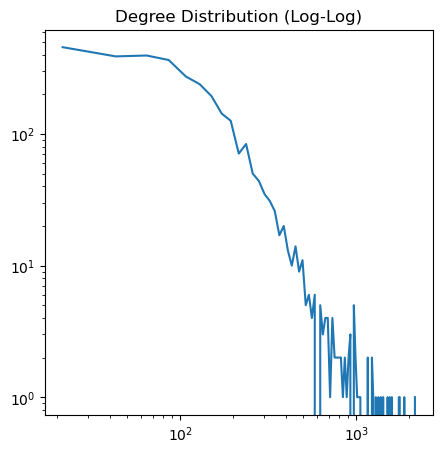

Average degree is:  125.30496453900709


In [27]:
# degree distribution.
degree_dict = dict(nx.degree(G))
degree_counts = degree_dict.values()

degree_hist, degree_bins, _ = plt.hist(degree_counts, bins=100)
plt.close()

fig, ax = plt.subplots(figsize = (5, 5))
ax.loglog(degree_bins[1:], degree_hist)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(title = 'Degree Distribution (Log-Log)')
plt.show()

print("Average degree is: ", np.mean(list(degree_counts)))


In [28]:
# Components
print(nx.number_connected_components(G))

74


[Text(0.5, 1.0, 'Size of Connected Components (Log-Log)')]

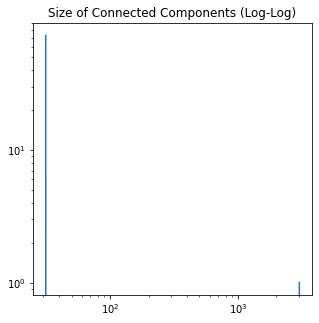

In [11]:
# components
# one giant component + 73 islands...
S = [len(c.copy()) for c in nx.connected_components(G)]
S

connect_hist, connect_bins, _ = plt.hist(S, bins=100)
plt.close()

fig, ax = plt.subplots(figsize = (5, 5))
ax.loglog(connect_bins[1:], connect_hist)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(title = 'Size of Connected Components (Log-Log)')
plt.show()


In [29]:
# obtain clustering coeffcient.
clustering_dict = nx.clustering(G)
clustering_keys = clustering_dict.keys()
clustering_values = clustering_dict.values()

In [30]:
# average clustering coefficient
print("Average clustering coefficient is: ", np.mean(list(clustering_values)))

Average clustering coefficient is:  0.5211911114522122


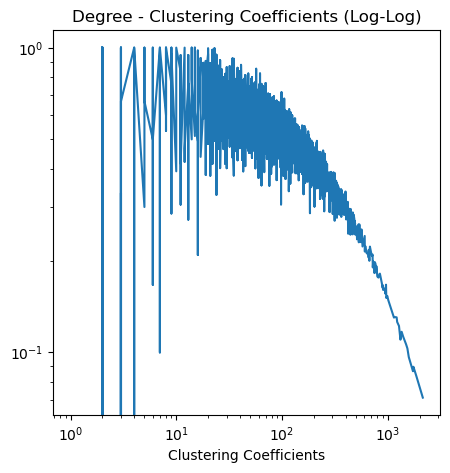

In [31]:
# clustering_values
degree_counts

degree_cluster_df = pd.DataFrame([list(degree_counts), list(clustering_values)]).T
degree_cluster_df.columns = ['degree', 'clustering_coeff']
degree_cluster_df = degree_cluster_df.sort_values('degree').reset_index()
degree_cluster_df

fig, ax = plt.subplots(figsize = (5, 5))
ax.loglog(degree_cluster_df['degree'], degree_cluster_df['clustering_coeff'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_xlabel('Clustering Coefficients')
ax.set(title = 'Degree - Clustering Coefficients (Log-Log)')
plt.show()


In [ ]:
# Component diameter
# I did not get the value. Very slow.
largest_G_nodes = max(nx.connected_components(G), key=len)
largest_sub_G = G.subgraph(largest_G_nodes)
print(nx.diameter(largest_sub_G)) # it takes time to compute.
